# Face Recognition implemetation on Google colab using openCV cascade detector, faceNet pre-train model, and SVM classifier

# Import Data and model files from Drive



In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from keras.models import load_model
import numpy as np
from matplotlib import pyplot
from random import choice
from mtcnn.mtcnn import MTCNN
from numpy import load
import cv2
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

# Extract a face from image using Cascade detector

In [108]:
def extract_face(filename, required_size=(160, 160)):
  # load image from file
  image = cv2.imread(filename)
  # convert to array
  pixels = asarray(image)
  # create the detector
  haar_cascade_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  # detect faces in the image
  results = haar_cascade_face.detectMultiScale(pixels, scaleFactor = 1.2, minNeighbors = 5)
  # extract the bounding box from the first face
  for (x, y, w, h) in results:
        x1, y1 = abs(x), abs(y)
        x2, y2 = x + w, y + h
        image = pixels[y1:y2, x1:x2]
  # extract the face
  image = Image.fromarray(image)
  image = image.resize(required_size)
  face_array = asarray(image)
  face_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2RGB)
  return face_array

# Example of face extracting result

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


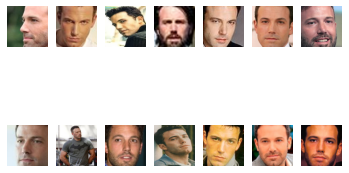

In [109]:
# specify folder to plot
folder = '/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

# load images and extract faces for all images in a directory


In [110]:
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each person that in turn contains images

In [111]:
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train and test datasets


In [112]:
trainX, trainy = load_dataset('/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
testX, testy = load_dataset('/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 21 examples for class: jerry_seinfeld
>loaded 22 examples for class: mindy_kaling
>loaded 17 examples for class: elton_john
>loaded 19 examples for class: madonna
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: madonna
(25, 160, 160, 3) (25,)


# load the face dataset

In [113]:
data = np.load('/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


# load the facenet model


In [114]:
model = load_model('/content/drive/My Drive/Colab Notebooks/facenet_keras.h5')
print('Loaded Model')

Loaded Model


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# get the face embedding for one face using faceNet model


In [115]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = np.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [116]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

(93, 128)
(25, 128)


# load dataset after faces embedding

In [117]:
data = np.load('/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


# Fit the SVM model

In [118]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=94.624, test=100.000


# Test the model

Predicted: jerry_seinfeld (89.662)
Expected: jerry_seinfeld


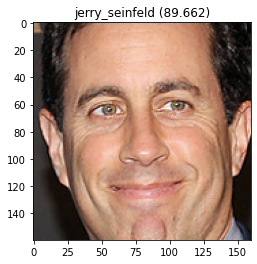

In [121]:
# load faces
data = load('/content/drive/My Drive/Colab Notebooks/5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()